In [2]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import CoolProp.CoolProp as CP
import nlopt
from scipy import stats, optimize
from sklearn import linear_model
mpl.use('TkAgg')
import matplotlib.pyplot as plt
from tridag import *
######################################################################
# Plot configurations
# mpl.style.use('classic')
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['lines.dashed_pattern'] = [6, 6]
mpl.rcParams['lines.dashdot_pattern'] = [3, 5, 1, 5]
mpl.rcParams['lines.dotted_pattern'] = [1, 3]
mpl.rcParams['lines.scale_dashes'] = False

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
######################################################################
%matplotlib inline

In [3]:
#Adsorption experimental data

pv_exp=[0.06, 0.24, 0.47, 0.59, 0.71, 0.94, 1.00, 1.06, 1.12, 1.18, 1.29, 1.41,\
    1.53, 1.82, 2.24, 2.71, 2.94, 3.18]

cout_exp=[0, 0, 0, 0, 0.043839945, 0.23571823, 0.393948895, 0.579304041,\
0.682607092, 0.789883458, 0.920350084, 0.955819637, 0.983220378, 1.001877569, 0.997183646,\
0.997183646, 1.001877569, 1.001877569]


In [4]:
bc      = np.rec.array([(1.), (0.)], 
          dtype=[('bcL','float64'), ('bcR','float64'),])

numpar  = np.rec.array([(1000), (10), (3.5), (0), (0), (0), (0)], 
          dtype=[('nx','int64'), ('alfa1','float64'), ('tstop','float64'), 
                ('dx','float64'), ('dt','float64'),
                ('alfa3','float64'), ('nt','int64'),])

physpar = np.rec.array([(60),(10.),(600.)], 
          dtype=[('peclet','float64'), ('k','float64'), ('beta','float64')])

varspatial  = np.rec.array([(np.zeros([numpar.nx,1])), (np.zeros([numpar.nx,1]))], 
          dtype=[('cmod_old','float64'), ('cmod','float64'), ])



numpar.dx      = 1/float(numpar.nx)
numpar.dt      = numpar.alfa1*numpar.dx
numpar.alfa3   = numpar.dt/(physpar.peclet*(numpar.dx**2))
numpar.nt      = int(numpar.tstop/numpar.dt)#+1e-6 

pv = np.arange(0.0, numpar.tstop+numpar.dt, numpar.dt)
vartemporal = np.rec.array([(pv), (np.zeros([len(pv)])), (np.zeros([len(pv)]))], 
          dtype=[('pv','float64'), ('cout','float64'),('time','float64') ])

In [5]:
a = np.zeros([numpar.nx,3])
b = np.zeros([numpar.nx,1])
alfa4 = np.zeros([numpar.nx,1])

for j in range(0,numpar.nt):
        alfa4 = 1 + physpar.k/(1+physpar.beta*varspatial.cmod_old)**2
        a[:,0]=-(numpar.alfa1+numpar.alfa3)
        a[1:numpar.nx-1,1]=alfa4[1:numpar.nx-1,0]+numpar.alfa1+2*numpar.alfa3
        a[0,1]=alfa4[0,0]+numpar.alfa1+3*numpar.alfa3
        a[numpar.nx-1,1]=alfa4[numpar.nx-1,0]+numpar.alfa1+numpar.alfa3
        a[:,2]=-numpar.alfa3
        varspatial.cmod_old[0,0]=varspatial.cmod_old[0,0]*alfa4[0,0]+\
                 (numpar.alfa1+2*numpar.alfa3)*bc.bcL
        varspatial.cmod=tridag(a,varspatial.cmod_old,numpar.nx);
        varspatial.cmod_old=varspatial.cmod
        vartemporal.cout[j+1]=varspatial.cmod[numpar.nx-1,0]
        vartemporal.time[j+1]=vartemporal.time[j]+numpar.dt

<function matplotlib.pyplot.tight_layout>

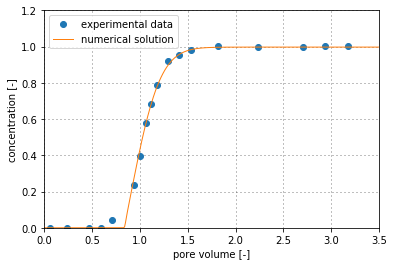

In [6]:
plt.plot(pv_exp,cout_exp,'o',label='experimental data')
plt.plot(vartemporal.pv,vartemporal.cout,markersize=10,label='numerical solution')
plt.xlabel('pore volume [-]')
plt.ylabel('concentration [-]')
plt.legend()
plt.grid()
plt.tight_layout